# Introduction 
In this code we're going to wok through an extended example that demonstrates how randomization inference works. As noted in the lecture, we are working through the example of a randomized assignment of men and women to eat (or not eat) soybeans and we are measuring the level of estrogen present in each of their bloodstreams (perhaps in parts/million).


# Make Data 

First, we create a grouping variable with two groups, one called "Man", and another called "Woman". 

> Alex apologizes that David couldn't come up with an example that is either more interesting or less gender-binary. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame({'group': np.repeat(a=['man', 'woman'], repeats=20)})
df.tail()

,group
35,woman
36,woman
37,woman
38,woman
39,woman


To these groups, we assign silly, but schematically heplful *potential outcomes* to treatment and control. We say that, by some chance, we sampled men into our study that had estrogen ppm levels that ranged from 1-20, in perfect increments. Also, what luck, but we sampled women into the study that had estrogen levels that ranged from 51-70. So, the women have on average higher estrogen beginning the study. 

In [3]:
df['po_control'] = np.concatenate([np.arange(1,21), np.arange(51,71)], axis=None)
df['po_treat'] = df['po_control'] # no effect because potential outcomes are the same 

Because we're going to use this later, let's wrap this *universe* creation into a function. 

In [4]:
def make_data(effect_size): 
    '''
    This dataframe is going to be hardcoded to have 40 folks, 20 "M" and 20 "F". 
    The only argument is the magnitude of the difference between po_control and _treat
    '''
    
    df = pd.DataFrame({'group': np.repeat(a=['man', 'woman'], repeats=20)})
    df['po_control'] = np.concatenate([np.arange(1,21), np.arange(51,71)], axis=None)
    df['po_treat'] = df['po_control'] + effect_size
    
    return(df)

df = make_data(effect_size=0)
df.head()

,group,po_control,po_treat
0,man,1,1
1,man,2,2
2,man,3,3
3,man,4,4
4,man,5,5


Once the data is built, it is then we can start to consider actually interviening in the world to conduct the experiment. 

# Conduct Experiment 

Per our randomization scheme, we are going to randomly assign the individuals to either: 

- Eat lots of tofu `(treatment == 1)`; or, 
- Not eat lots of tofu `(treatment == 0)`. 

To do this, we write a simple function that will randomly place zeros and ones for the treatment and control. 

In [5]:
def randomize(reps): 
    urn = np.repeat([0,1], repeats=reps)
    np.random.shuffle(urn)
    return(urn)

With our randomization function in hand, we can now "**run an experiment**" which is going to: 

1. Assign people to treatment or control; 
2. If they're in treatment, we will see their potential outcomes to treatment; and, 
3. If they're in contorl, we will see their potential outcomes to control. 

Functionally, this is simply storing the results of our function randomize in a vector object called treatment, and then recording the correct potential outcome value. 

In [6]:
def run_experiment(reps): 
    df['treat'] = randomize(reps)
    
    df['Y'] = np.NaN
    df.loc[df['treat']==0, 'Y'] = df.loc[df['treat']==0, 'po_control']
    df.loc[df['treat']==1, 'Y'] = df.loc[df['treat']==1, 'po_treat']
    
    return(df[['group', 'treat', 'Y']])

In [7]:
df = run_experiment(20)
df.tail()

,group,treat,Y
35,woman,1,66.0
36,woman,0,67.0
37,woman,1,68.0
38,woman,0,69.0
39,woman,0,70.0


Recall that we are setting up an experiment that has **no** effect. As Green and Gerber point out in *Field Experiments* in the case of the sharp-null, we are actually testing against the possiblity that we observe both the potential outcoems! Cool.

Next, we create a vector of realized outcomes, first using the compact notation that Green and Gerber prefer using maths. For those randomized to treamtent, we multiply the potential outcome to treatment time the treatment vector (which is a 1 when they were assigned to treatment), and for those in control, into this vector we assign the potential outcome to control time the quantity `(1 - treatment)` which will be one when they are in the treatment group. 

# Ok so we've got our data set up. Now what? 
Now that we have the data set up, we can begin to examine what the lecture is really about, what is the distribution of ATE that we observe due to the different possibly assignments to treatment and control. A few points to remember: 

1. From last week: The difference in sample means between the treatment and control groups is an unbiased estimator of the ATE. 
2. Also from last week: This does not imply that any one realization of treatment/control assignment is guaranteed to exactly produce that ATE.

This is the entire point of understanding the distribution of the ATE. 

To get here, first lets write another function that will calculate the ATE. 


In [8]:
def estimate_ate(df): 
    '''This takes a df with names treat and Y.'''
    res = df[['treat', 'Y']].groupby('treat').mean()
    ate = res.diff()['Y'][1]
    
    return(ate)

In [9]:
ate = estimate_ate(df)
ate

-6.0999999999999943

## What gives?!

We created this data such that there is *exactly* zero treament effect, but when we look at this summary of the outcomes, they're not **exactly** the same! *Shouldn't they have been?* 

Note, even more specifically than creating the data so that there was no *average treatment effect* we constructed this so that there was no effect at all -- for every single person, `po_control == po_treat`. 


What happens if you go back to the top and run the experiment again? Are the numbers internally consistent, even if they're producing a result that doesn't seem to make sense? Go back up and look at these again. 

## Question of Understanding 

.

.

.

.

.

.

Why are these values different each time you run your experiment? 

> Answer here. 

## More Work with this 

Lets rewrite our function just slightly so that rather than pulling the results frame, instead we're pulling the estimated average treatment effect from the experiment. This is just going to index into the values, and compute the difference between them. 

In [10]:
def sim_experiment(_df = df, reps=20): 
    _df['treat'] = randomize(reps)
    res = _df[['treat', 'Y']].groupby('treat').mean()
    res = res.diff()
    return(res.iloc[1]['Y'])

In [11]:
df.head()

,group,treat,Y
0,man,0,1.0
1,man,1,2.0
2,man,1,3.0
3,man,0,4.0
4,man,1,5.0


In [12]:
f'The ate under the sharp null is: {sim_experiment()}.'

'The ate under the sharp null is: -11.799999999999997.'

In [13]:
f'The ate under the sharp null is: {sim_experiment()}.'

'The ate under the sharp null is: -0.09999999999999432.'

In [14]:
f'The ate under the sharp null is: {sim_experiment()}.'

'The ate under the sharp null is: 1.9000000000000057.'

What we're seeing is that there are some slightly different outcomes to different trement regimes. 

We can do this, a bunch more times using some simple list comprehension. Specifically, do this 1,000 times to get a sense of the distribution. 


In [15]:
experiments = [sim_experiment() for _ in range(0,1000)]

In [16]:
experiments[0:10]

[-14.400000000000002,
 5.5999999999999943,
 -7.0999999999999979,
 14.099999999999998,
 18.0,
 14.0,
 -4.5999999999999943,
 0.5,
 -4.5,
 7.7000000000000028]

Text(0.5,0,'RI ATE')

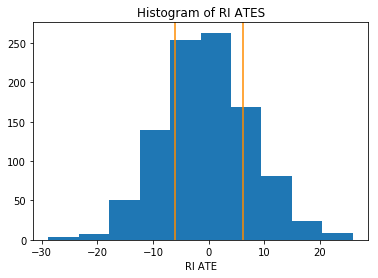

In [17]:
%matplotlib inline

plt.hist(experiments)
plt.axvline(x=ate, color = 'darkorange')
plt.axvline(x = -1 * ate, color = 'darkorange')
plt.title('Histogram of RI ATES')
plt.xlabel('RI ATE')

As it turns out, that was pretty similar to what we saw in our draw! 

In [18]:
ate

-6.0999999999999943

In fact, what we've got here is pretty likely to turn up by chance. 

Following David's statment, we can draw a probability of seeing an ATE of a given size under the repeated randomization regime. 

For how many of these randomization inference loops was the *randomization inference* ate more extreme than the observed ate when you **actually** ran the experiment? 

In [19]:
def p_value(ate, ri_dist): 
    test_vector = np.abs(ri_dist) > np.abs(ate)
    test_vector = test_vector.astype('int')
    
    p_value = test_vector.mean()

    return(p_value)

In [20]:
p_value(ate=ate, ri_dist=experiments)

0.436

In [21]:
# If you want to see each of the sides of this happen; you might consider 
# reading this version of the same function. 
#
# def p_value(ate, ri_dist): 
#     if np.sign(ate) == -1: 
#         negative_vals = (ri_dist < ate).astype('int').mean()
#         positive_vals = (ri_dist > -1 * ate).astype('int').mean()
#     elif np.sign(ate) == 1: 
#         negative_vals = (ri_dist < -1 * ate).astype('int').mean()
#         positive_vals = (ri_dist > ate).astype('int').mean()
#     pvalue = negative_vals + positive_vals
#    
#     return(pvalue)
#
# p_value(ate=ate, ri_dist=experiments)

In [22]:
experiments_no_effect = experiments

# Simulate an Experiment with a Large Effect 

We have seen that when there is no effect, our Randomization Inference regime does a good job at assigning a high probability of observing an effect size equal to or larger than the ATE we calculate from our particular randomization. 

Now, let's show that when there is a big effect, our Randomization Inference regime does a good job at assigning a low probability of observing an effect size equal to or larger that the ATE we calculate in our regression. 


In [23]:
df = make_data(effect_size=25)

In [24]:
df = run_experiment(reps=20)
df.iloc[:10, ]

,group,treat,Y
0,man,1,26.0
1,man,1,27.0
2,man,0,3.0
3,man,1,29.0
4,man,0,5.0
5,man,1,31.0
6,man,0,7.0
7,man,0,8.0
8,man,0,9.0
9,man,0,10.0


If that is the data that is generated from our actual experiment, how do we generate the average treatment effect? 

In [25]:
ate = estimate_ate(df)
ate

26.299999999999997

If that is the estimated ate, what do we get for a histogram of randomization inference? 

In [26]:
f'The ate under the assumption of the sharp null is {sim_experiment()}.'

'The ate under the assumption of the sharp null is -10.200000000000003.'

In [27]:
f'The ate under the assumption of the sharp null is {sim_experiment()}.'

'The ate under the assumption of the sharp null is -0.9000000000000057.'

## Question of Understanding 

1. Are the values under the randomization inference loops (a result of `sim_experiment`) changing? 
2. Should they be? Why or why not? 



## Randomization Inference Under A Strong Effect 

The previous time that we stepped through a series of randomiation inference loops, we had built the data so that there was *specifically* no effect. And, when we examined the distribution of the treatment effects that could have been possible under:  

- The observed data; 
- Presuming the sharp null was true; 

We saw that the distribution was centered at zero, and that a *lot* of the simulated distribution was more extreme than the treatment effect that we generated. 

Text(0.5,1,'The old example')

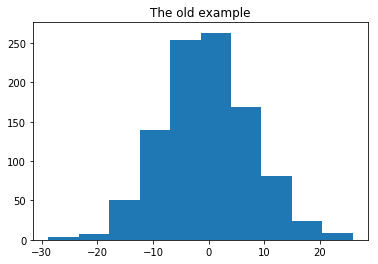

In [28]:
plt.hist(experiments_no_effect)
plt.title('The old example')

## Current Example 
Lets simulate these randomization inference loops again, this time with the 25 unit treatment effect. 

In [29]:
experiments = [sim_experiment(_df = df) for _ in range(1000)]

Before you plot this histogram: 

- Where do you think the histogram of randomization inference loops *should* be located? Should it be centered at either: 
    - Zero
    - 25
- Why? 
- Will this histogram have the same general *shape* as the previous histogram? Why or why not? 

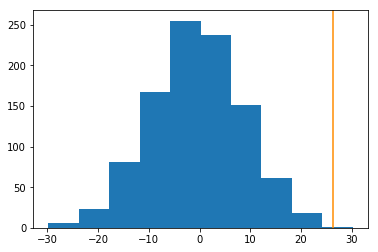

In [30]:
plt.hist(experiments)
plt.axvline(x=ate, color = 'darkorange')

Produce a statement of the test for how likely a treatment effect of this size is to occur under the presumption of the sharp null hypothesis? (This will be using the `p_value` function that we previously wrote. 

In [31]:
p_value(ate=ate, ri_dist=experiments)

0.0030000000000000001